In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import k_fold_cross_validation as cv
import mlp_backprop_momentum as mlp

%matplotlib inline

PATH = './voice_recognition/vowels/'

In [2]:
# Compute the sum of a row for a given array
def rowTotal(arr, row):
    total = 0
    
    for i in range(len(arr)):
        total += arr[row][i]
    return total

# Compute the sum of a column for a given array
def columnTotal(arr, column):
    total = 0
    
    for i in range(len(arr)):
        total += arr[i][column]
    return total

# Compute the sum of a diagonal for a given array
def diagTotal(arr):
    total = 0
    
    for i in range(len(arr)):
        total += arr[i][i]
    return total

# Read files passed as argument
def read(files):
    values = []
    
    for file in files:
        values.append(wav.read(os.path.join(PATH, file)))
    
    return values
# Compute mfcc features    
def generate_mfcc(files):
    mfcc_array = []
    for (val, X) in files:
        mfcc_array.append(mfcc(X, samplerate = val, nfft = 1024))
        
    return mfcc_array

# Compute mean of mfcc features
def mean_compute(mfcc):
    values = []
    
    for val in mfcc:
        mean = np.mean(val, axis = 0)
        values.append(mean)
    return values

#Compute scaled mfcc features
def scale(values, min, max):
    val = (values - values.min(axis = 0)) *(max - min)
    divider = values.max(axis = 0) - values.min(axis = 0)
    divider[divider == 0] = 1
    return min + val / divider

# Compute the standard deviation of mfcc features
def std_compute(mfcc):
    values = []
    
    for val in mfcc:
        deviation = np.std(val, axis = 0)
        values.append(deviation)
    return values

# Compute the median of mfcc features
def median_compute(mfcc):
    values = []
    
    for feature in mfcc:
        median = np.median(feature,axis=0)
        values.append(median)
    return values


In [3]:
men = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('nam') and file.endswith('.wav'))]

women = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and file.startswith('naf') and file.endswith('.wav'))]

children_files = [file for file in os.listdir(PATH) if (os.path.isfile(os.path.join(PATH, file)) and (file.startswith('nk') or file.startswith('sk')) and file.endswith('.wav'))]

In [4]:
# loading data
m_data = read(men) 
w_data= read(women)
c_data = read(children_files)

    
m_mfcc = generate_mfcc(m_data) # men mfcc 
w_mfcc = generate_mfcc(w_data) # women mfcc
c_mfcc = generate_mfcc(c_data) # children mfcc

m_feature = mean_compute(m_mfcc)
w_feature = mean_compute(w_mfcc)
c_feature = mean_compute(c_mfcc)


In [5]:
values = []
WOMAN = [1,-1,-1]
MAN = [-1,1,-1]
CHILD = [-1,-1,1]

for value in c_feature:
    values.append(np.append(value, CHILD))

for value in w_feature:
    values.append(np.append(value, WOMAN))
    
for value in m_feature:
    values.append(np.append(value, MAN))
    
values = scale(np.asarray(values), -1, 1)

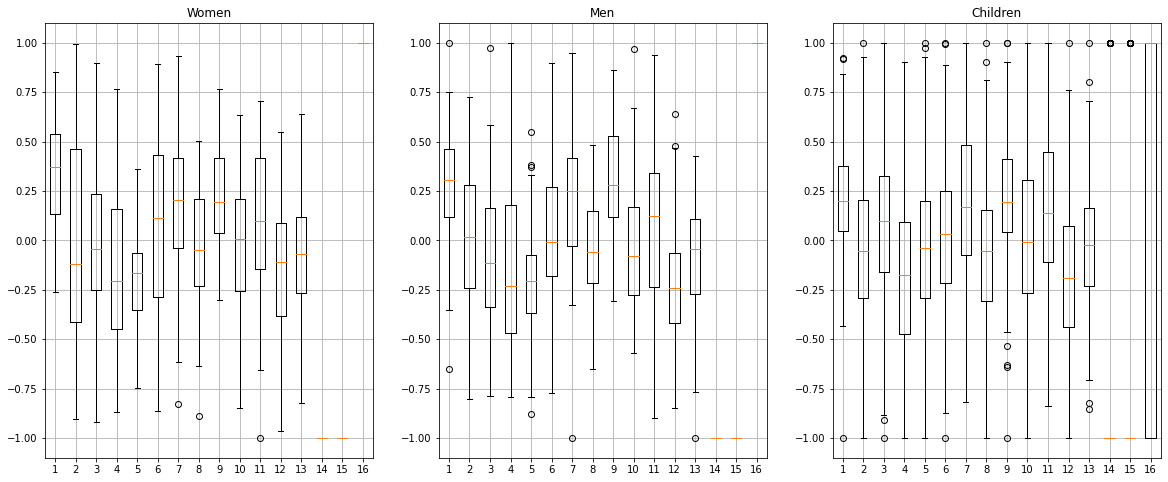

In [13]:
pl.figure(figsize=(20,8))
pl.subplot(1,3,1)
pl.boxplot(values[:50])
pl.title('Women')
pl.grid()

pl.subplot(1,3,2)
pl.boxplot(values[50:100])
pl.title('Men')
pl.grid()

pl.subplot(1,3,3)
pl.boxplot(values[100:])
pl.title('Children')
pl.grid()

In [14]:
NB_NEURONS = [2,5,10,20,30]
LEARN_RATE = 0.001
MOMENTUM = 0.5
NUM_INITS = 10
EPOCHS = 3000

input = values[:,0:13]
output = values[:,13]

MSE = np.zeros((len(NB_NEURONS), NUM_INITS, EPOCHS))

print('TEST BEGIN')     
# Test the model with different number of neurons                           
for i_h, h in enumerate(NB_NEURONS):     
    print('Test with : ', h, 'neurons in hidden layer')
    # Test the model with different number of initializations
    layer = mlp.MLP([13, h, 3], 'tanh')
    for i in np.arange(NUM_INITS):                                      
        layer.init_weights()
        MSE[i_h, i, :] = layer.fit((input, output),
                                learning_rate=LEARN_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

TEST BEGIN
Test with :  2 neurons in hidden layer
Test with :  5 neurons in hidden layer
Test with :  10 neurons in hidden layer
Test with :  20 neurons in hidden layer
Test with :  30 neurons in hidden layer


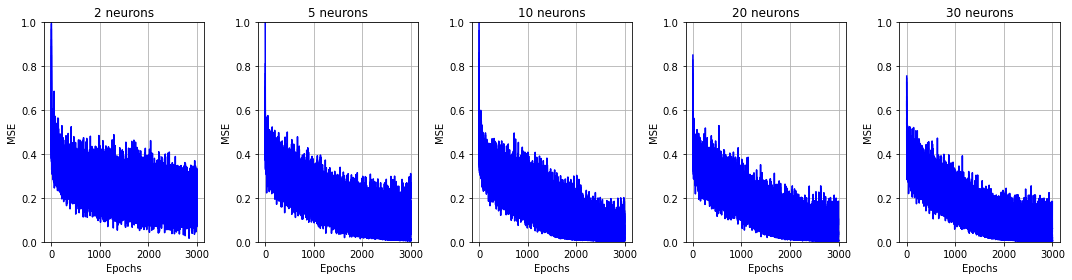

In [15]:
pl.figure(figsize=(15,4))
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(NB_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [16]:
K = 5
EPOCHS = 600
NB_TESTS = 8
NB_NEURONS = [2, 5, 10, 20, 30, 45]

test_set = np.zeros((len(NB_NEURONS), EPOCHS, NB_TESTS))
train_set = np.zeros((len(NB_NEURONS), EPOCHS, NB_TESTS))

In [17]:
for i_h, h in enumerate(NB_NEURONS):          # number of neurons in hidden layer                           
    print('Test with : ', h, 'neurons in hidden layer')
    layer = mlp.MLP([13, h, 3], 'tanh')
    for i in np.arange(NB_TESTS):                          # number of tests             
        layer.init_weights()                                   # initialize weights            
        val1, val2 = cv.k_fold_cross_validation_per_epoch(layer,         # perform k-fold cross validation
                                                            values,      # data
                                                            k=K,        # number of folds
                                                            learning_rate=LEARN_RATE, # learning rate
                                                            momentum=MOMENTUM,  # momentum
                                                            epochs=EPOCHS) # number of epochs
        train_set[i_h, :, i] = val1
        test_set[i_h, :, i] = val2

Test with :  2 neurons in hidden layer
Test with :  5 neurons in hidden layer
Test with :  10 neurons in hidden layer
Test with :  20 neurons in hidden layer
Test with :  30 neurons in hidden layer
Test with :  45 neurons in hidden layer


In [18]:
mean_train_set = np.mean(train_set, axis=2)
mean_test_set = np.mean(test_set, axis=2)
sd_train_set = np.std(train_set, axis=2)
sd_test_set = np.std(test_set, axis=2)

# find minimal and maximal value
v_min = min(np.min(mean_train_set), np.min(mean_test_set))
v_max = max(np.max(mean_train_set), np.max(mean_test_set))

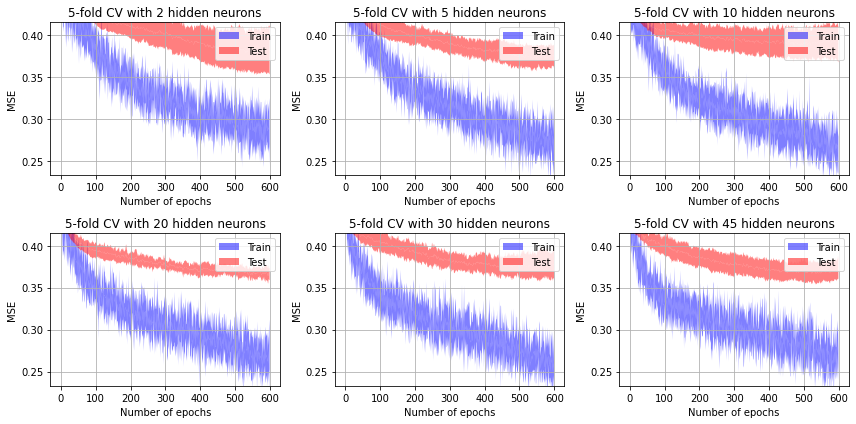

In [19]:

nb_rows = int(np.ceil(len(NB_NEURONS) / 3.0))
pl.figure(figsize=(12,3 * nb_rows))

# plot mean and standard deviation of training and test set
for i_n, n in enumerate(NB_NEURONS):
    pl.subplot(nb_rows, min(3, len(NB_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), mean_train_set[i_n,:], mean_train_set[i_n,:]+sd_train_set[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), mean_train_set[i_n,:], mean_train_set[i_n,:]-sd_train_set[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), mean_test_set[i_n,:], mean_test_set[i_n,:]+sd_test_set[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), mean_test_set[i_n,:], mean_test_set[i_n,:]-sd_test_set[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95 * v_min, 0.5 * v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

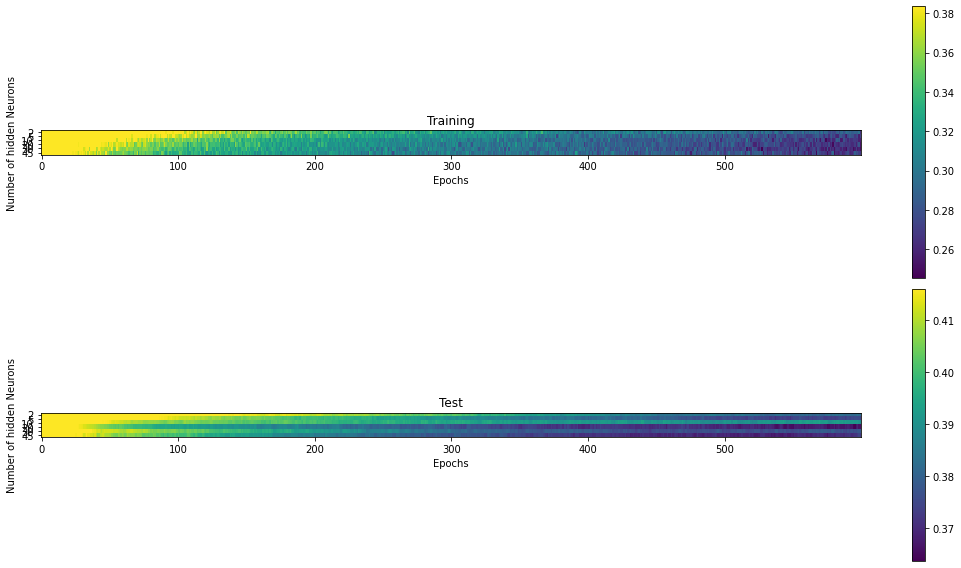

In [20]:
# Display the train set
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(mean_train_set, vmin=np.min(mean_train_set), vmax=np.percentile(mean_train_set, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(NB_NEURONS)), NB_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()

# Display the test set
pl.subplot(2,1,2)
pl.imshow(mean_test_set, vmin=np.min(mean_test_set), vmax=np.percentile(mean_test_set, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(NB_NEURONS)), NB_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [21]:
K = 5
LEARN_RATE = 0.001
MOMENTUM = 0.5
EPOCHS = 500
NB_NEURONS = 25

b_MSE_train = 2 # best MSE train
b_MSE_test = 2 # best MSE test
b_f_score = 2 # best f-score

w_MSE_train = -1 # worst MSE train
w_MSE_test = -1 # worst MSE test
w_f_score = -1 # worst f-score

w_conf_mat = np.zeros((3, 3)) # worst confusion matrix
b_conf_mat = np.zeros((3, 3)) # best confusion matrix
results = np.zeros((3, 3))

for i in range(0, 3):
    w_conf_mat[i][i] = len(c_mfcc)

mean_train_set = 0
mean_test_set = 0

nn = mlp.MLP([13, NB_NEURONS, 3], 'tanh')


In [22]:
for i in range(0, 100):
    # fold cross validation
    MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                               values,
                                                               k=K,
                                                               learning_rate=LEARN_RATE,
                                                               momentum=MOMENTUM,
                                                               epochs=EPOCHS,
                                                               threshold=0.0)
    # compute best and worst MSE train
    if b_MSE_train > MSE_train:
        b_MSE_train = MSE_train
    elif w_MSE_train < MSE_train:
        w_MSE_train = MSE_train
     # compute best and worst MSE test
    if b_MSE_test > MSE_test:
        b_MSE_test = MSE_test
    elif w_MSE_test < MSE_test:
        w_MSE_test = MSE_test
    
# compute results for confusion matrix
for j in range(0, 3):
    for k in range(0, 3):
        results[j][k] += conf_mat[j][k]

corrects = diagTotal(conf_mat)
if diagTotal(b_conf_mat) < corrects:
    best_conf_mat = conf_mat
elif diagTotal(w_conf_mat) > corrects:
    worst_conf_mat = conf_mat
 
mean_train_set += MSE_train
mean_test_set += MSE_test

KeyboardInterrupt: 

In [126]:
print("------------------------------------------------------")
print("MSE part\n")
print("Best MSE train: " + str(b_MSE_train))
print("Best MSE test: " + str(b_MSE_test))
print("Worst MSE train: " + str(w_MSE_train))
print("Worst MSE test: " + str(w_MSE_test))

print("\nF-score part\n")
print("Best f-score: " + str(b_f_score))
print("Worst f-score: " + str(w_f_score))

print("\nConfusion matrix part\n")
print("Best confusion matrix : ")
print(b_conf_mat)
print("Worst confusion matrix : ")
print(w_conf_mat)


for i in range(0, 3):
    for j in range(0, 3):
        results[i][j] /= 10
print("------------------------------------------------------")

print("------------------------------------------------------")

print("Mean part\n")

print("     matrix : ")
print(results)

print("------------------------------------------------------")

print("------------------------------------------------------")

# Women
w_recall = results[1][1] / columnTotal(results, column=1)
w_precision = results[1][1] / rowTotal(results, row=1)
w_f1 = 2 * w_precision * w_recall / (w_precision + w_recall)

# Men
m_recall = results[0][0] / columnTotal(results, column=0)
m_precision = results[0][0] / rowTotal(results, row=0)
m_f1 = 2 * m_precision * m_recall / (m_precision + m_recall)

# Child
c_recall = results[2][2] / columnTotal(results, column=2)
c_precision = results[2][2] / rowTotal(results, row=2)
c_f1 = 2 * c_precision * c_recall / (c_precision + c_recall)

print("------------------------------------------------------")


print("------------------------------------------------------")

print("Recall: ".ljust(19, ' '), ( w_recall + m_recall + c_recall) / 3)
print("\nPrecision: ".ljust(20, ' '), (w_precision + m_precision + c_precision) / 3)
print("\nF1: ".ljust(19, ' '), (w_f1 + m_f1 + c_f1) / 3)

print("------------------------------------------------------")


------------------------------------------------------
MSE part

Best MSE train: 0.009655638284687431
Best MSE test: 0.049805605615387535
Worst MSE train: 0.011859572850962587
Worst MSE test: 0.2424145617770231

F-score part

Best f-score: 2
Worst f-score: -1

Confusion matrix part

Best confusion matrix : 
[[36.  0.]
 [ 0. 36.]]
Worst confusion matrix : 
[[34.  2.]
 [ 4. 32.]]
------------------------------------------------------
------------------------------------------------------
Mean part

     matrix : 
[[3.507e-09 9.300e-11]
 [1.700e-10 3.430e-09]]
     precision:       0.9537666576013054
     recall:         0.9741666666666666
     F1 Score:       0.9638587329943659
------------------------------------------------------
